# GMM4PR Analysis  
## Load GMM
This notebook loads trained GMM models from fit_gmm2.py

In [1]:
import os
import torch
from utils import GMM4PR, get_dataset, build_model, build_decoder_from_flag
from typing import Tuple, Dict, Any

def load_gmm_config(gmm_path: str) -> Dict[str, Any]:
    """
    Load the configuration from a saved GMM checkpoint.
    
    Args:
        gmm_path: Path to the GMM checkpoint file (.pt)
        
    Returns:
        Dictionary containing both GMM config and full experiment config
    """
    if not os.path.isfile(gmm_path):
        raise FileNotFoundError(f"GMM checkpoint not found: {gmm_path}")
    
    ckpt = torch.load(gmm_path, map_location="cpu", weights_only=False)
    
    if "config" not in ckpt:
        raise ValueError(f"No config found in checkpoint: {gmm_path}")
    
    gmm_config = ckpt["config"]
    
    # The full experiment config is stored inside gmm_config["config"]
    exp_config = gmm_config.get("config", {})
    
    print(f"✓ Loaded config from: {gmm_path}")
    print(f"  Experiment: {exp_config.get('exp_name', 'N/A')}")
    print(f"  Dataset: {exp_config.get('dataset', 'N/A')}")
    print(f"  Architecture: {exp_config.get('arch', 'N/A')}")
    print(f"  K: {gmm_config['K']}, latent_dim: {gmm_config['latent_dim']}")
    print(f"  Condition mode: {gmm_config.get('cond_mode', 'None')}")
    print(f"  Covariance type: {gmm_config.get('cov_type', 'diag')}")
    print(f"  Perturbation: {gmm_config.get('budget', {})}")
    
    return gmm_config


def load_gmm_model(gmm_path: str, device: str = "cuda") -> Tuple[GMM4PR, Any, Any, Any]:
    """
    Load a complete GMM model from checkpoint with all necessary components.
    
    Args:
        gmm_path: Path to the GMM checkpoint file (.pt)
        device: Device to load the model to ('cuda' or 'cpu')
        
    Returns:
        Tuple of (gmm_model, classifier_model, feat_extractor, up_sampler)
    """
    # Step 1: Load configuration
    gmm_config = load_gmm_config(gmm_path)
    exp_config = gmm_config.get("config", {})
    
    # Extract necessary config values
    dataset_name = exp_config.get("dataset", "cifar10")
    data_root = exp_config.get("data_root", "./dataset")
    arch = exp_config.get("arch", "resnet18")
    clf_ckpt = exp_config.get("clf_ckpt")
    use_decoder = exp_config.get("use_decoder", False)
    decoder_backend = exp_config.get("decoder_backend", "bicubic")
    latent_dim = gmm_config["latent_dim"]
    
    # Step 2: Load dataset to get output shape
    print(f"\n{'='*60}")
    print("Loading dataset...")
    dataset, num_classes, out_shape = get_dataset(dataset_name, data_root, train=True, resize=False)
    print(f"  Dataset: {dataset_name}, Classes: {num_classes}, Shape: {out_shape}")
    
    # Step 3: Load classifier and feature extractor
    print(f"\n{'='*60}")
    print(f"Loading classifier: {arch}")
    print(f"  Device: {device}")
    
    if not clf_ckpt or not os.path.isfile(clf_ckpt):
        raise FileNotFoundError(f"Classifier checkpoint not found: {clf_ckpt}")
    
    model, feat_extractor = build_model(arch, num_classes, device)
    
    # Load classifier weights
    state = torch.load(clf_ckpt, map_location="cpu", weights_only=False)
    state = state.get("state_dict", state.get("model_state", state))
    state = {k.replace("module.", ""): v for k, v in state.items()}
    
    model.load_state_dict(state, strict=False)
    model = model.to(device).eval()
    for p in model.parameters():
        p.requires_grad = False
    
    feat_extractor = feat_extractor.to(device).eval()
    for p in feat_extractor.parameters():
        p.requires_grad = False
    
    # Check parameter sharing
    model_params = {id(p) for p in model.parameters()}
    feat_params = {id(p) for p in feat_extractor.parameters()}
    shared = model_params & feat_params
    
    print(f"  Model params: {len(model_params)}, Feat extractor params: {len(feat_params)}")
    if shared:
        print(f"  Shared parameters: {len(shared)}")
    
    # Step 4: Build decoder/up_sampler if needed
    up_sampler = None
    if use_decoder:
        print(f"\n{'='*60}")
        print(f"Building decoder: {decoder_backend}")
        up_sampler = build_decoder_from_flag(
            decoder_backend,
            latent_dim,
            out_shape,
            device
        )
        print(f"  ✓ Decoder built successfully!")
    else:
        print(f"\n{'='*60}")
        print(f"No decoder used (use_decoder={use_decoder})")
    
    # Step 5: Load the GMM model
    print(f"\n{'='*60}")
    print(f"Loading GMM model from: {gmm_path}")
    gmm = GMM4PR.load_from_checkpoint(
        gmm_path,
        feat_extractor=feat_extractor,
        up_sampler=up_sampler,
        map_location=device,
        strict=True
    )
    
    gmm = gmm.to(device).eval()
    print(f"✓ GMM model loaded successfully!")
    print(f"{'='*60}\n")
    
    return gmm, gmm_config, model, feat_extractor, up_sampler


print("Functions defined: load_gmm_config(), load_gmm_model()")

# Example usage: Load a GMM model from checkpoint

# Specify the GMM checkpoint path
# GMM_PATH = "./ckp/gmm_ckp/resnet18_on_cifar10/gmm_K7_cond(xy)_decoder(trainable_128)_linf(16)_reg(none).pt"
GMM_PATH = "ckp/gmm_ckp/resnet18_on_cifar10/gmm_K3_cond(x)_decoder(nontrainable)_linf(16)_reg(none).pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the complete GMM model
gmm, cfg, model, feat_extractor, up_sampler = load_gmm_model(GMM_PATH, device=DEVICE)

# The loaded components are now ready to use:
# - gmm: The trained GMM4PR model
# - model: The classifier model
# - feat_extractor: The feature extractor
# - up_sampler: The decoder (if used)

print("\nAll components loaded and ready for analysis!")


/home/wang3_z@WMGDS.WMG.WARWICK.AC.UK/miniconda3/envs/WSPR/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/wang3_z@WMGDS.WMG.WARWICK.AC.UK/miniconda3/envs/WSPR/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/wang3_z@WMGDS.WMG.WARWICK.AC.UK/miniconda3/envs/WSPR/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_

Functions defined: load_gmm_config(), load_gmm_model()
✓ Loaded config from: ckp/gmm_ckp/resnet18_on_cifar10/gmm_K3_cond(x)_decoder(nontrainable)_linf(16)_reg(none).pt
  Experiment: K3_cond(x)_decoder(nontrainable)_linf(16)_reg(none)
  Dataset: cifar10
  Architecture: resnet18
  K: 3, latent_dim: 48
  Condition mode: x
  Covariance type: full
  Perturbation: {'norm': 'linf', 'eps': 0.06274509803921569}

Loading dataset...
Files already downloaded and verified
  Dataset: cifar10, Classes: 10, Shape: (3, 32, 32)

Loading classifier: resnet18
  Device: cuda
  Model params: 62, Feat extractor params: 60
  Shared parameters: 60

Building decoder: bicubic
[Decoder 'bicubic'] 0 params
  ✓ Decoder built successfully!

Loading GMM model from: ckp/gmm_ckp/resnet18_on_cifar10/gmm_K3_cond(x)_decoder(nontrainable)_linf(16)_reg(none).pt
[Params] Shared trunk: 131,840 | pi: 771 | mu: 37,008, | cov: 1,908,224 | Total: 1,946,003
Model loaded from ckp/gmm_ckp/resnet18_on_cifar10/gmm_K3_cond(x)_decoder(n

/home/wang3_z@WMGDS.WMG.WARWICK.AC.UK/WSPR/utils/gmm4pr.py:992: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=map_location)


## Computation of PR

In [2]:
cfg

{'K': 3,
 'latent_dim': 48,
 'T_pi': 1.0,
 'T_mu': 1.0,
 'T_sigma': 1.0,
 'T_shared': 1.0,
 'logstd_bounds': (-3.0, 1.0),
 'budget': {'norm': 'linf', 'eps': 0.06274509803921569},
 'reg_coeffs': {'pi_entropy': 0.0, 'mean_diversity': 0.0},
 'has_y_emb': False,
 'y_emb_dim': None,
 'y_emb_normalize': True,
 'cond_mode': 'x',
 'cov_type': 'full',
 'cov_rank': 0,
 'feat_dim': 512,
 'num_cls': 10,
 'hidden_dim': 256,
 'config': {'device': 'cuda',
  'num_workers': 2,
  'seed': 42,
  'init_mode': 'uniform',
  'check_collapse_every': 10,
  'ckp_dir': './ckp/gmm_ckp',
  'exp_name': 'K3_cond(x)_decoder(nontrainable)_linf(16)_reg(none)',
  'dataset': 'cifar10',
  'data_root': './dataset',
  'resize': False,
  'arch': 'resnet18',
  'clf_ckpt': './model_zoo/trained_model/sketch/resnet18_cifar10.pth',
  'K': 3,
  'latent_dim': 48,
  'cond_mode': 'x',
  'cov_type': 'full',
  'cov_rank': 0,
  'hidden_dim': 256,
  'use_y_embedding': False,
  'y_emb_dim': 0,
  'y_emb_normalize': False,
  'use_decoder': T

In [76]:
from utils import compute_pr_on_clean_correct

test_dataset, num_classes, out_shape = get_dataset("cifar10", "./dataset", train=False, resize=False)
# Create DataLoader for evaluation
loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Set number of samples per image
S_SAMPLES = 100  # Number of Monte Carlo samples per image

# Optional: Specify batch indices to evaluate (None = all batches)
# BATCH_INDICES = None  # Evaluate all batches
# BATCH_INDICES = [0, 1, 2, 3, 4]  # Evaluate only first 5 batches
BATCH_INDICES = range(50)  # Evaluate batches 100 to 199

print(f"\nComputing PR on clean-correct samples...")
print(f"  GMM: {cfg['config']['exp_name']}")
print(f"  Samples per image: {S_SAMPLES}")
print(f"  Batch indices: {'All' if BATCH_INDICES is None else BATCH_INDICES}")

# Compute PR
pr, n_used, clean_acc = compute_pr_on_clean_correct(
    model=model,
    gmm=gmm,
    loader=loader,
    out_shape=out_shape,
    device=DEVICE,
    num_samples=500,
    batch_indices=range(10),
    temperature=1,  # Very low temperature should approximate hard sampling
    use_soft_sampling=False,
    chunk_size=32
)

print(f"\n{'='*60}")
print(f"Results:")
print(f"  Clean Accuracy: {clean_acc*100:.2f}%")
print(f"  Probabilistic Robustness (PR): {pr}")
print(f"  Clean-correct samples used: {n_used}")
print(f"{'='*60}")

Files already downloaded and verified

Computing PR on clean-correct samples...
  GMM: K12_cond(xy)_decoder(trainable_128)_linf(16)_reg(none)
  Samples per image: 100
  Batch indices: range(0, 50)
[PR@clean] used=4401 / seen=5120 (clean acc=85.96%), num_samples=500, chunk_size=32 → PR=0.8937 [method: hard (categorical)]

Results:
  Clean Accuracy: 85.96%
  Probabilistic Robustness (PR): 0.8937337017687741
  Clean-correct samples used: 4401


## Plot the distribution 
### Point analysis on given inputs 


In [6]:
from utils.viz_gmm import cov_to_full, plot_tensor_bars
import torch 
import matplotlib.colors as mcolors

INPUT_IDX = 0
blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)

# 8 inputs 
loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

for x, y, _ in loader:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    print(f"Input x shape: {x.shape}, y shape: {y.shape}, y: {y}, y[idx]: {y[INPUT_IDX]}")
    break 

if cfg.get("cond_mode") == "x":
    gmm_dist = gmm(x = x)
    print(f"condtional mode: {cfg.get('cond_mode')}, input index: {INPUT_IDX}")
elif cfg.get("cond_mode") == "y":
    gmm_dist = gmm(y = y)
    print(f"condtional mode: {cfg.get('cond_mode')}, input index: {INPUT_IDX}")
elif cfg.get("cond_mode") == "xy":
    gmm_dist = gmm(x = x, y = y)
    print(f"condtional mode: {cfg.get('cond_mode')}, input index: {INPUT_IDX}")
elif cfg.get("cond_mode") in ["none", None]: # my fault, I forgot which one I used
    gmm_dist = gmm()
    print(f"condtional mode: {cfg.get('cond_mode')}")
else:
    raise ValueError(f"Unknown cond_mode: {cfg.get('cond_mode')}")

mix = gmm_dist["dist"].mixture_distribution
comp = gmm_dist["dist"].component_distribution

pi_b = mix.probs
if isinstance(gmm_dist['dist'].component_distribution, torch.distributions.independent.Independent):
    mu_b = comp.base_dist.loc            # mean of each Gaussian
    cov_b = comp.base_dist.scale
elif isinstance(gmm_dist['dist'].component_distribution, torch.distributions.multivariate_normal.MultivariateNormal):
    mu_b = comp.loc
    cov_b = comp.covariance_matrix


pi = pi_b[INPUT_IDX]
mu = mu_b[INPUT_IDX] 

K = pi.shape[0] # number of components
D = mu.shape[1] # feature dimension

# for full Sigma setup
if gmm.cov_type == "diag":
    Sigma = cov_to_full(cov_b[INPUT_IDX], "diag") # (K,D,D)
elif gmm.cov_type == "full":
    Sigma = cov_to_full(cov_b[INPUT_IDX], "full")
else:
    U, sigma = cov_b
    Sigma = cov_to_full((U[INPUT_IDX], sigma[INPUT_IDX]), "lowrank")

print(pi.shape, mu.shape, Sigma.shape)  # (K,), (K,D), (K,D,D)

Input x shape: torch.Size([8, 3, 32, 32]), y shape: torch.Size([8]), y: tensor([3, 8, 8, 0, 6, 6, 1, 6], device='cuda:0'), y[idx]: 3
condtional mode: None
torch.Size([7]) torch.Size([7, 128]) torch.Size([7, 128, 128])


### Bar plot of $\pi_k$ 

(<Figure size 395x320 with 1 Axes>,
 <Axes: title={'center': 'Mixture weights $\\pi$'}, xlabel='Component $k$', ylabel='$\\pi_k$'>)

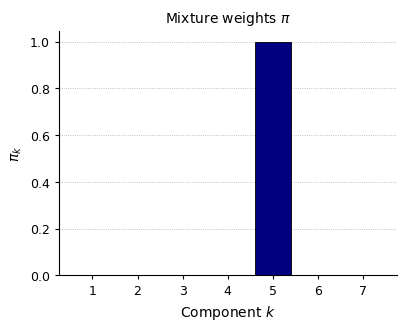

In [7]:
plot_tensor_bars(pi, xticks_step=1, 
                 titles=r"Mixture weights $\pi$", 
                 ylabel=r"$\pi_k$", 
                 xlabel=r"Component $k$",
                 color="navy")

### PCA for component distributions 

In [8]:
from utils.viz_gmm import pick_projection
proj, proj_2d = pick_projection(Sigma, pi, max_dim=32)  # (D,d) (D,2)

# projection for each component
mu_proj = mu @ proj        # (K,d)
Sigma_proj = torch.stack([proj.t() @ Sigma[k] @ proj for k in range(K)], dim=0)  # (K,d,d)

# 2-d projection for contour plot
mu_proj_2d = mu @ proj_2d  # (K,2)
Sigma_proj_2d = torch.stack([proj_2d.T @ Sigma[k] @ proj_2d for k in range(K)], dim=0)  # (K,2,2)

# Add regularization to ensure positive definiteness (fix numerical issues)
eps = 1e-6
Sigma_proj_2d = Sigma_proj_2d + eps * torch.eye(2).unsqueeze(0).to(Sigma_proj_2d.device)  # (K,2,2)

### Bar plot for $\mu_k$

(<Figure size 900x780 with 7 Axes>,
 array([[<Axes: title={'center': 'K=1'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=2'}>, <Axes: title={'center': 'K=3'}>],
        [<Axes: title={'center': 'K=4'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=5'}>, <Axes: title={'center': 'K=6'}>],
        [<Axes: title={'center': 'K=7'}, ylabel='$\\mu$'>, <Axes: >,
         <Axes: >]], dtype=object))

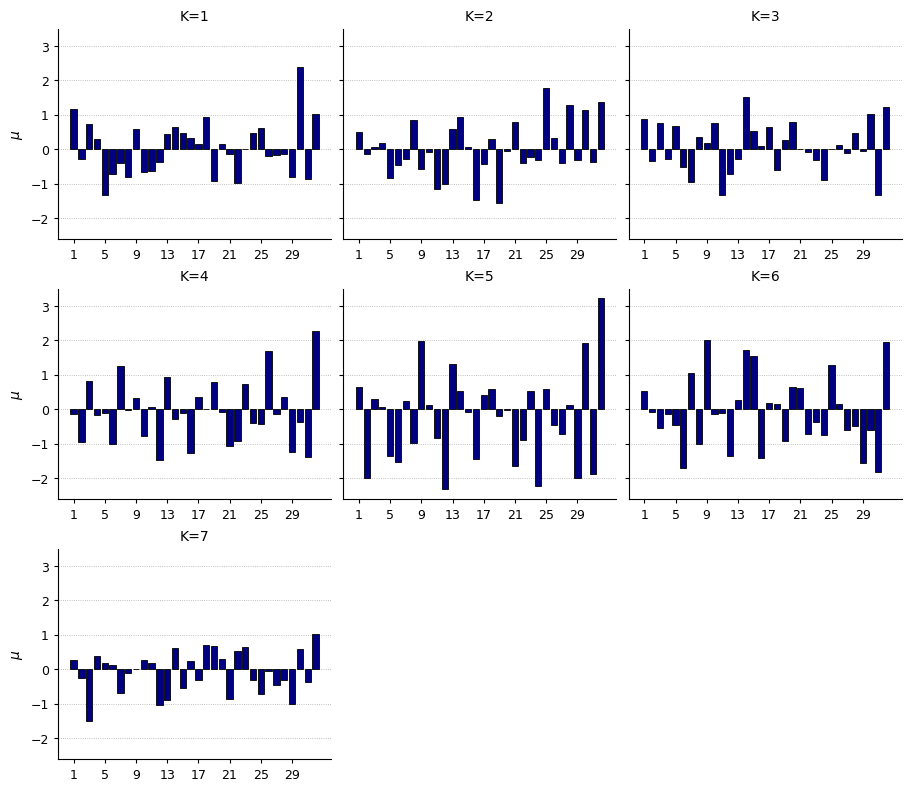

In [9]:
plot_tensor_bars(mu_proj, xticks_step=4, 
                 titles=[f"K={i+1}" for i in range(K)], 
                 ylabel=r"$\mu$",
                 color="navy")

### Heat map for $\Sigma_k$

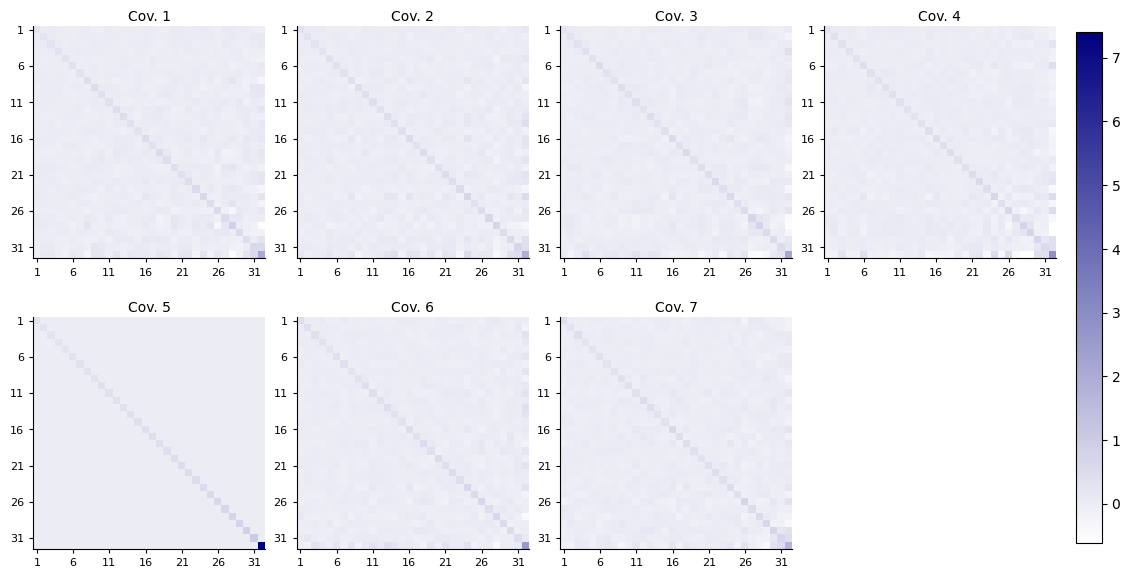

In [10]:
import matplotlib.colors as mcolors
from utils.viz_gmm import plot_tensor_heatmaps
import matplotlib.pyplot as plt

blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)

plot_tensor_heatmaps(
    Sigma_proj,
    titles=[rf"$\Sigma_{i+1}$" for i in range(3)],
    nrows=5, ncols=4,        # 手动 1 行 3 列
    reverse_cmap=True,       # 颜色对调
    share_color=True,
    xtick_step=5,
    cmap=blue_cmap
)
plt.show()


### Sample from the prjected GMM parameters

In [11]:
import numpy as np
from utils import g_ball
def sample_gmm_torch(n_samples, weights, means, covariances, device="cpu", seed=None):
    """
    Sample from a Gaussian Mixture Model (GMM) using PyTorch.
    
    Parameters
    ----------
    n_samples : int
        Total number of samples to generate.
    weights : torch.Tensor, shape (K,)
        Mixture weights of each component, must sum to 1.
    means : torch.Tensor, shape (K, d)
        Mean vectors of each component.
    covariances : torch.Tensor, shape (K, d, d)
        Covariance matrices of each component.
    device : str
        Device to store tensors ("cpu" or "cuda").
    seed : int, optional
        Random seed for reproducibility.
    
    Returns
    -------
    samples : torch.Tensor, shape (n_samples, d)
        Generated samples.
    labels : torch.Tensor, shape (n_samples,)
        Component label of each sample.
    """
    if seed is not None:
        torch.manual_seed(seed)

    K, d = means.shape

    # 1. Sample component indices according to mixture weights
    labels = torch.multinomial(weights, num_samples=n_samples, replacement=True)

    # 2. Generate samples from the corresponding Gaussian distribution
    samples = torch.zeros((n_samples, d), device=device)
    for k in range(K):
        idx = (labels == k).nonzero(as_tuple=True)[0]
        n_k = idx.numel()
        if n_k > 0:
            dist = torch.distributions.MultivariateNormal(
                loc=means[k],
                covariance_matrix=covariances[k]
            )
            samples[idx] = dist.sample((n_k,))

    return samples.to(device), labels.to(device)


# Example: GMM with 2 components
# weights = torch.tensor([0.4, 0.6], dtype=torch.float32)
# means = torch.tensor([[0.0, 0.0], [3.0, 3.0]], dtype=torch.float32)
# covariances = torch.tensor([[[1.0, 0.5], [0.5, 1.0]], 
#                             [[1.0, -0.3], [-0.3, 1.0]]], dtype=torch.float32)


# Split into x and y for plotting

samples, labels = sample_gmm_torch(200, pi.cpu(), mu_proj_2d.cpu(), Sigma_proj_2d.cpu(), seed=42)

samples = samples.numpy()
# Split into x and y for plotting


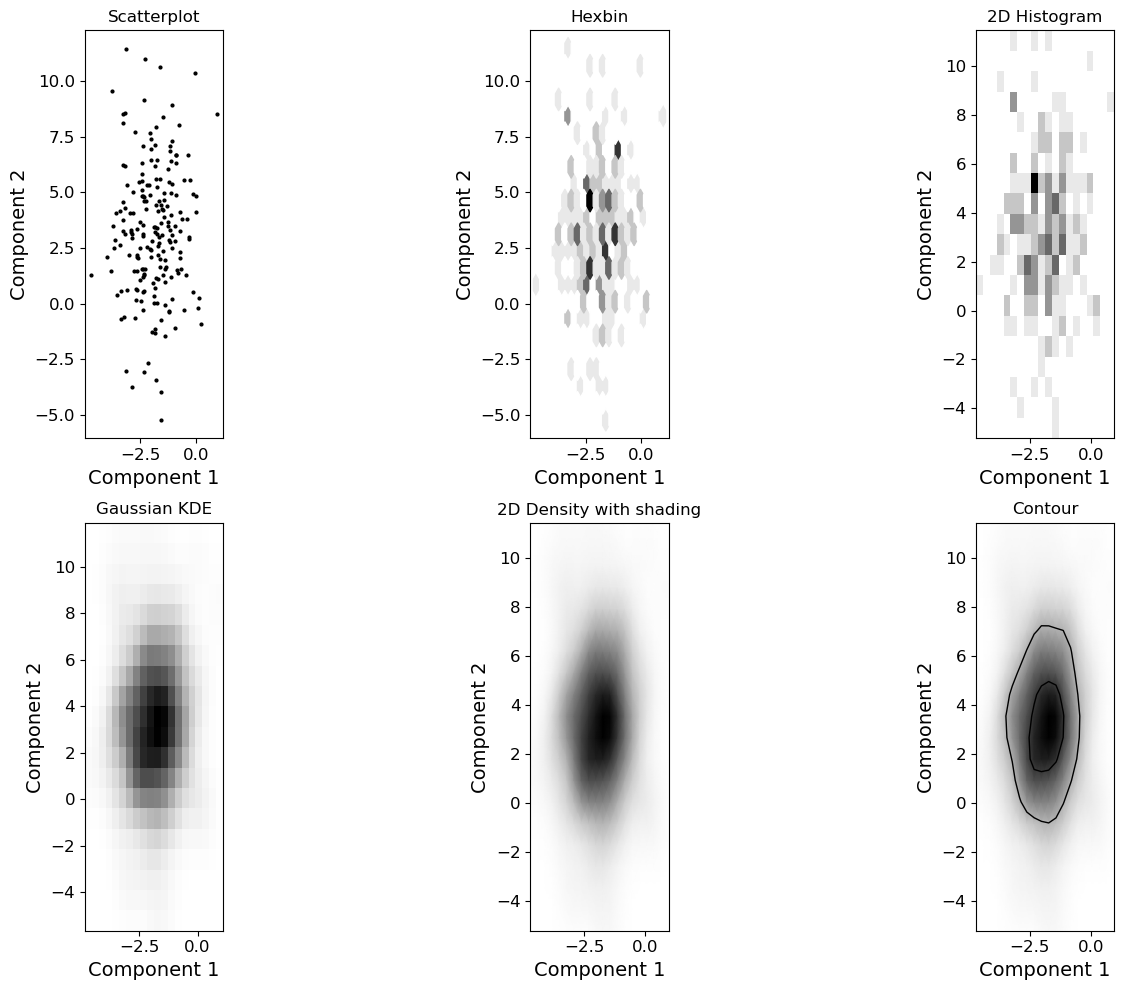

(<Figure size 1500x1000 with 6 Axes>,
 array([<Axes: title={'center': 'Scatterplot'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Hexbin'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': '2D Histogram'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Gaussian KDE'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': '2D Density with shading'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Contour'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [19]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde 


def plot_contours(samples, 
                  subplots_to_show=[0, 1, 2, 3, 4, 5],
                  show_titles=True,
                  ticklabelsize_x=12,
                  ticklabelsize_y=12,
                  labelsize_x=14,
                  labelsize_y=14,
                  figsize=None,
                  show_xlabel=True,
                  show_ylabel=True):
    """
    Plot 2D distribution visualizations in a 2x3 grid.
    
    Parameters
    ----------
    samples : numpy.ndarray
        2D samples array of shape (N, 2)
    subplots_to_show : list of int
        List of subplot indices to display (0-5). 
        0: Scatterplot, 1: Hexbin, 2: 2D Histogram,
        3: Gaussian KDE, 4: 2D Density with shading, 5: Contour
        Default: [0, 1, 2, 3, 4, 5] (show all)
    show_titles : bool
        Whether to show subplot titles (default: True)
    ticklabelsize_x : int
        Font size for x-axis tick labels (default: 12)
    ticklabelsize_y : int
        Font size for y-axis tick labels (default: 12)
    figsize : tuple or None
        Figure size (width, height). If None, auto-computed based on subplots shown
    
    show_xlabel : bool
        Whether to show x-axis label (default: False)
    show_ylabel : bool
        Whether to show y-axis label (default: False)
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    axes : numpy.ndarray
        Array of axes objects
    """
    x, y = samples[:, 0], samples[:, 1]
    
    # Validate subplots_to_show
    subplots_to_show = [idx for idx in subplots_to_show if 0 <= idx <= 5]
    if not subplots_to_show:
        raise ValueError("At least one subplot index must be specified (0-5)")
    
    # Calculate layout based on number of subplots
    num_subplots = len(subplots_to_show)
    ncols = min(3, num_subplots)
    nrows = int(np.ceil(num_subplots / ncols))
    
    # Auto-compute figure size if not provided
    if figsize is None:
        figsize = (5 * ncols, 5 * nrows)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    # Ensure axes is always a 1D array
    if num_subplots == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])
    
    # Subplot titles
    titles = ['Scatterplot', 'Hexbin', '2D Histogram', 
              'Gaussian KDE', '2D Density with shading', 'Contour']
    
    # Pre-compute KDE for subplots that need it (3, 4, 5)
    kde_computed = False
    if any(idx in subplots_to_show for idx in [3, 4, 5]):
        nbins = 20
        kde = gaussian_kde(samples.T)
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        kde_computed = True
    
    # Plot each requested subplot
    for plot_idx, subplot_idx in enumerate(subplots_to_show):
        ax = axes[plot_idx]
        
        # Plot based on subplot type
        if subplot_idx == 0:  # Scatterplot
            ax.plot(x, y, 'o', color='black', markersize=2)
            
        elif subplot_idx == 1:  # Hexbin
            nbins = 20
            ax.hexbin(x, y, gridsize=nbins, cmap='Greys')
            
        elif subplot_idx == 2:  # 2D Histogram
            nbins = 20
            ax.hist2d(x, y, bins=nbins, cmap='Greys')
            
        elif subplot_idx == 3:  # Gaussian KDE
            ax.pcolormesh(xi, yi, zi, cmap='Greys')
            
        elif subplot_idx == 4:  # 2D Density with shading
            ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap='Greys')
            
        elif subplot_idx == 5:  # Contour
            ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap='Greys')
            ax.contour(xi, yi, zi, levels=2, colors='black', linewidths=1)
        
        # Set title if requested
        if show_titles:
            ax.set_title(titles[subplot_idx])
        
        # Set aspect ratio and tick parameters
        
        # Set axis labels if requested
        if show_xlabel:
            ax.set_xlabel('Component 1', fontsize=labelsize_x)
        if show_ylabel:
            ax.set_ylabel('Component 2', fontsize=labelsize_y)
        ax.set_aspect('equal')
        ax.tick_params(axis='x', labelsize=ticklabelsize_x)
        ax.tick_params(axis='y', labelsize=ticklabelsize_y)
    
    # Hide unused subplots
    for idx in range(num_subplots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes


# Example usage with all subplots
plot_contours(samples)

# Example: Show only specific subplots
# plot_contours(samples, subplots_to_show=[0, 5], show_titles=False, 
#               ticklabelsize_x=14, ticklabelsize_y=14)

# Example: Show only scatter and contour plots with larger tick labels
# plot_contours(samples, subplots_to_show=[0, 5], ticklabelsize_x=16, ticklabelsize_y=16)

### PCA for high-dimensional sampels

In [13]:
from sklearn.decomposition import PCA
import torch
import numpy as np
import matplotlib.colors as mcolors


def reduce_samples_dimension_pca(samples, output_dim, return_pca_object=False):
    """
    Reduce the dimension of high-dimensional samples using PCA.
    
    Args:
        samples: High-dimensional samples, shape (n_samples, D)
                 Can be torch.Tensor or numpy.ndarray
        output_dim: Target dimensionality (int)
        return_pca_object: If True, also return the fitted PCA object
        
    Returns:
        samples_reduced: Low-dimensional samples, shape (n_samples, output_dim)
                        Same type as input (torch.Tensor or numpy.ndarray)
        pca (optional): Fitted PCA object (if return_pca_object=True)
    """
    # Check input type
    is_torch = isinstance(samples, torch.Tensor)
    device = samples.device if is_torch else None
    
    # Convert to numpy if necessary
    if is_torch:
        samples_np = samples.detach().cpu().numpy()
    else:
        samples_np = samples
    
    n_samples, D = samples_np.shape
    
    # Validate output_dim
    if output_dim > D:
        raise ValueError(f"output_dim ({output_dim}) cannot be larger than input dimension ({D})")
    if output_dim <= 0:
        raise ValueError(f"output_dim must be positive, got {output_dim}")
    
    # Fit PCA
    pca = PCA(n_components=output_dim)
    samples_reduced_np = pca.fit_transform(samples_np)
    
    # Print information
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"PCA Dimension Reduction: {D} -> {output_dim}")
    print(f"  Number of samples: {n_samples}")
    print(f"  Explained variance ratio: {explained_variance_ratio}")
    print(f"  Cumulative explained variance: {cumulative_variance[-1]:.4f}")
    
    # Convert back to torch if necessary
    if is_torch:
        samples_reduced = torch.from_numpy(samples_reduced_np).float().to(device)
    else:
        samples_reduced = samples_reduced_np
    
    if return_pca_object:
        return samples_reduced, pca
    else:
        return samples_reduced


print("Function 'reduce_samples_dimension_pca' loaded successfully!")
print("Usage: reduced_samples = reduce_samples_dimension_pca(samples, output_dim=2)")


INPUT_IDX = 0
NUM_SAMPLES = 200
TARGET_DIM = 2  # Can change this to any dimension you want

blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)

loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)

for x, y, _ in loader:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    break 

# generating high-dimensional samples from GMM

if cfg.get("cond_mode") == "x":
    gmm_samples = gmm.sample(x = x, num_samples=NUM_SAMPLES)
    print(f"condtional mode: {cfg.get('cond_mode')}, input index: {INPUT_IDX}")
elif cfg.get("cond_mode") == "y":
    gmm_samples = gmm.sample(y = y, num_samples=NUM_SAMPLES, out_shape=out_shape)
    print(f"condtional mode: {cfg.get('cond_mode')}, input index: {INPUT_IDX}")
elif cfg.get("cond_mode") == "xy":
    gmm_samples = gmm.sample(x = x, y = y, num_samples=NUM_SAMPLES)
    print(f"condtional mode: {cfg.get('cond_mode')}, input index: {INPUT_IDX}")
elif cfg.get("cond_mode") in ["none", None]: # my fault, I forgot which one I used
    gmm_samples = gmm.sample(num_samples=NUM_SAMPLES, out_shape=out_shape)
    print(f"condtional mode: {cfg.get('cond_mode')}")
else:
    raise ValueError(f"Unknown cond_mode: {cfg.get('cond_mode')}")

samples_high_dim = gmm_samples["delta"][:, 0, ...].reshape(gmm_samples["delta"].shape[0], -1)  # (N,D)


print(f"\nReducing dimension from {samples_high_dim.shape[-1]} to {TARGET_DIM} using PCA...")
samples_low_dim = reduce_samples_dimension_pca(samples_high_dim, output_dim=TARGET_DIM)

print(f"\nReduced samples shape: {samples_low_dim.shape}")
print(f"Input shape: {samples_high_dim.shape} -> Output shape: {samples_low_dim.shape}")

Function 'reduce_samples_dimension_pca' loaded successfully!
Usage: reduced_samples = reduce_samples_dimension_pca(samples, output_dim=2)


condtional mode: None

Reducing dimension from 3072 to 2 using PCA...
PCA Dimension Reduction: 3072 -> 2
  Number of samples: 200
  Explained variance ratio: [0.748956   0.22862414]
  Cumulative explained variance: 0.9776

Reduced samples shape: torch.Size([200, 2])
Input shape: torch.Size([200, 3072]) -> Output shape: torch.Size([200, 2])


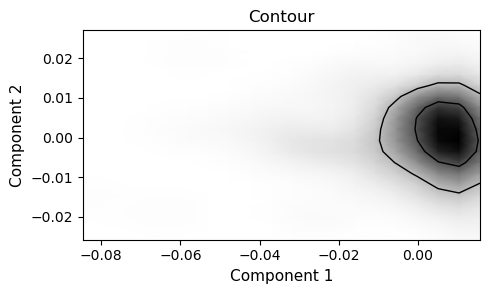

(<Figure size 500x500 with 1 Axes>,
 array([<Axes: title={'center': 'Contour'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [23]:
plot_contours(samples=samples_low_dim.cpu().numpy(), 
                subplots_to_show=[5],
                show_titles=True,
                ticklabelsize_x=10,
                ticklabelsize_y=10,
                labelsize_x=11,
                labelsize_y=11
                )

### One-dimension PCA and plot for x, xy conditional dependence

PCA explained variance ratio: 0.1770
Saved: gmm_ridgeline_plot.png


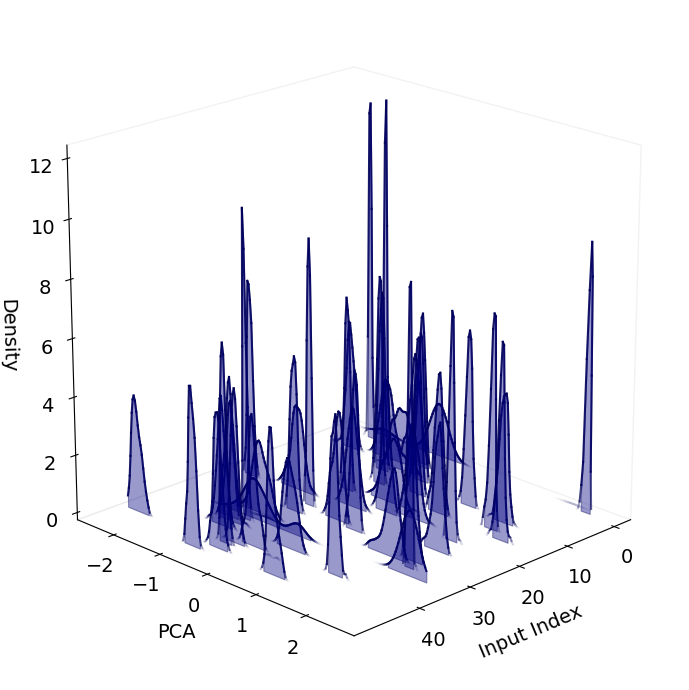

In [274]:
# ============================================================================
# Visualization: 1D PCA projection of GMM distributions per input
# Simple, clean style consistent with statistical journals
# ============================================================================

def _style_3d_axes(ax, show_grid=True):
    """Apply clean, minimal styling to 3D axes - consistent with journal style."""
    # Set pane colors to white
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Set pane edge colors to light gray
    ax.xaxis.pane.set_edgecolor('0.9')
    ax.yaxis.pane.set_edgecolor('0.9')
    ax.zaxis.pane.set_edgecolor('0.9')

    # Set grid style - sparser grid (only if show_grid is True)
    if show_grid:
        ax.grid(True, linestyle=':', linewidth=0.4, color='0.8', alpha=0.5)
    else:
        ax.grid(False)

    # Set spine colors to black
    ax.xaxis.line.set_color('0.0')
    ax.yaxis.line.set_color('0.0')
    ax.zaxis.line.set_color('0.0')


def visualize_gmm_1d_pca(gmm_samples, cfg, labels=None, num_inputs=8, x_tick_step=1, 
                        color='navy', fade_threshold=0.05, color_by_label=False,
                        palette='nature', use_delta=True,
                        ticklabelsize_x=9, ticklabelsize_y=9, ticklabelsize_z=9):
    """
    Visualize GMM distributions using 1D PCA projection in 3D.
    Clean, minimal style consistent with statistical journals.

    X-axis: Input index, Y-axis: PCA Component 1, Z-axis: Probability density

    Args:
        gmm_samples: Dictionary containing GMM samples with keys 'eps' and 'delta'
        cfg: Configuration dictionary
        labels: Labels for each input sample, shape (B,). Used when color_by_label=True
        num_inputs: Number of input samples to visualize
        x_tick_step: Step size for x-axis (input index) ticks. E.g., 2 means show every 2nd tick
        color: Single color for all curves (used when color_by_label=False). 
               Examples: 'navy', 'darkblue', 'steelblue', 'crimson', 'darkgreen'
        fade_threshold: Threshold (0-1) for fading low-density regions. 
                       Points below this fraction of max density will be more transparent
        color_by_label: If True, color curves by their labels (same label = same color)
                       and rearrange samples by label
        palette: Color palette style. Options: 'nature', 'science', 'cell', 'pnas'
        use_delta: If True, use 'delta' key from gmm_samples, otherwise use 'eps' (default: True)
        ticklabelsize_x: Font size for x-axis tick labels (default: 9)
        ticklabelsize_y: Font size for y-axis tick labels (default: 9)
        ticklabelsize_z: Font size for z-axis tick labels (default: 9)
    """
    
    # Select which samples to use based on use_delta flag
    if use_delta:
        # delta shape: [num_samples, B, C, H, W] -> reshape to [num_samples, B, C*H*W]
        samples_tensor = gmm_samples['delta']
        if samples_tensor.dim() > 3:
            # Reshape [num_samples, B, C, H, W] -> [num_samples, B, C*H*W]
            num_samples, B = samples_tensor.shape[0], samples_tensor.shape[1]
            samples_tensor = samples_tensor.reshape(num_samples, B, -1)
        latent_dim = samples_tensor.shape[2]
    else:
        # delta shape: [num_samples, B, latent_dim]
        samples_tensor = gmm_samples['eps']
        latent_dim = cfg['latent_dim']

    # Fit PCA on all samples to get a consistent projection
    all_samples = samples_tensor.reshape(-1, latent_dim).cpu().numpy()
    pca = PCA(n_components=1)
    pca.fit(all_samples)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")

    # Rearrange samples by label if color_by_label is True
    if color_by_label and labels is not None:
        # Convert labels to numpy
        if hasattr(labels, 'cpu'):
            labels_np = labels.cpu().numpy()
        else:
            labels_np = np.array(labels)
        
        # Sort indices by label
        sorted_indices = np.argsort(labels_np[:num_inputs])
        labels_sorted = labels_np[sorted_indices]
        
        # Rearrange samples accordingly
        samples_sorted = samples_tensor[:, sorted_indices, :]
        
        print(f"Samples rearranged by label. Order: {labels_sorted}")
    else:
        sorted_indices = np.arange(num_inputs)
        labels_sorted = labels.cpu().numpy()[:num_inputs] if labels is not None else None
        samples_sorted = samples_tensor[:, :num_inputs, :]

    # Collect data for all inputs
    all_proj_1d = []
    all_densities = []
    all_x_ranges = []

    # Get global min/max for consistent y-axis range
    global_min = np.inf
    global_max = -np.inf

    for i in range(num_inputs):
        samples = samples_sorted[:, i, :].cpu().numpy()  # [num_samples, latent_dim]
        proj_1d = pca.transform(samples).flatten()  # [num_samples]
        all_proj_1d.append(proj_1d)

        global_min = min(global_min, proj_1d.min())
        global_max = max(global_max, proj_1d.max())

    # Use global range for all KDEs
    y_range = np.linspace(global_min, global_max, 200)

    for i in range(num_inputs):
        proj_1d = all_proj_1d[i]

        # Estimate density
        kde = gaussian_kde(proj_1d)
        density = kde(y_range)

        all_densities.append(density)
        all_x_ranges.append(y_range)

    # Color assignment with scientific journal palettes
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    from matplotlib.patches import Patch
    
    # Define color palettes inspired by Nature, Science, Cell, PNAS
    palettes = {
        'nature': [
            '#E64B35',  # Red
            '#4DBBD5',  # Cyan
            '#00A087',  # Teal
            '#3C5488',  # Blue
            '#F39B7F',  # Salmon
            '#8491B4',  # Purple-blue
            '#91D1C2',  # Mint
            '#DC0000',  # Crimson
            '#7E6148',  # Brown
            '#B09C85',  # Tan
        ],
        'science': [
            '#3B4992',  # Deep blue
            '#EE0000',  # Red
            '#008B45',  # Green
            '#631879',  # Purple
            '#008280',  # Teal
            '#BB0021',  # Crimson
            '#5F559B',  # Violet
            '#A20056',  # Magenta
            '#808180',  # Gray
            '#1B1919',  # Black
        ],
        'cell': [
            '#1F77B4',  # Blue
            '#FF7F0E',  # Orange
            '#2CA02C',  # Green
            '#D62728',  # Red
            '#9467BD',  # Purple
            '#8C564B',  # Brown
            '#E377C2',  # Pink
            '#7F7F7F',  # Gray
            '#BCBD22',  # Yellow-green
            '#17BECF',  # Cyan
        ],
        'pnas': [
            '#0072B2',  # Blue
            '#D55E00',  # Vermillion
            '#009E73',  # Bluish green
            '#CC79A7',  # Reddish purple
            '#F0E442',  # Yellow
            '#56B4E9',  # Sky blue
            '#E69F00',  # Orange
            '#999999',  # Gray
            '#000000',  # Black
            '#882255',  # Purple
        ]
    }
    
    legend_handles = []
    
    if color_by_label and labels is not None:
        # Get unique labels in sorted order
        unique_labels = np.unique(labels_sorted)
        num_classes = len(unique_labels)
        
        # Select palette colors
        palette_colors = palettes.get(palette, palettes['nature'])
        
        # Create color mapping for each label
        label_to_color = {}
        for idx, label in enumerate(unique_labels):
            # Use palette colors cyclically if more classes than colors
            color_hex = palette_colors[idx % len(palette_colors)]
            c = mcolors.to_rgb(color_hex)
            label_to_color[label] = c
            # Create legend entry with thinner border
            legend_handles.append(Patch(facecolor=c, edgecolor='black', 
                                       linewidth=0.8, label=f'Class {label}'))
        
        # Assign colors based on sorted labels
        base_colors = []
        line_colors = []
        for i in range(num_inputs):
            label = labels_sorted[i]
            base_color = label_to_color[label]
            base_colors.append(base_color)
            line_colors.append(tuple(max(0, c - 0.15) for c in base_color))
        
        print(f"Color by label: {num_classes} unique classes found (using {palette} palette)")
    else:
        # Use single color for all curves
        base_color = mcolors.to_rgb(color)
        line_color = tuple(max(0, c - 0.15) for c in base_color)
        base_colors = [base_color] * num_inputs
        line_colors = [line_color] * num_inputs

    # ------------ Plot: Clean 3D Ridge Plot with Fading ------------
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')
    _style_3d_axes(ax, show_grid=False)

    for i in range(num_inputs):
        y_range_i = all_x_ranges[i]
        density = all_densities[i]
        x_vals = np.full_like(y_range_i, i)

        # Normalize density for alpha calculation
        max_density = density.max()
        
        # Create alpha values based on density (fade low-density regions)
        if max_density > 0:
            normalized_density = density / max_density
            # Apply fading: regions below threshold get reduced alpha
            alphas = np.where(normalized_density > fade_threshold, 
                            0.9, 
                            0.9 * (normalized_density / fade_threshold))
        else:
            alphas = np.ones_like(density) * 0.9

        # Plot density curve with variable alpha
        for j in range(len(y_range_i) - 1):
            avg_alpha = (alphas[j] + alphas[j+1]) / 2
            ax.plot([x_vals[j], x_vals[j+1]], 
                   [y_range_i[j], y_range_i[j+1]], 
                   [density[j], density[j+1]],
                   color=line_colors[i], linewidth=1.5, alpha=avg_alpha)

        # Fill under curve with subtle shading and fading
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        # Only fill regions above threshold
        mask = normalized_density > fade_threshold
        if np.any(mask):
            # Find contiguous regions above threshold
            regions = []
            start_idx = None
            for j in range(len(mask)):
                if mask[j] and start_idx is None:
                    start_idx = j
                elif not mask[j] and start_idx is not None:
                    regions.append((start_idx, j))
                    start_idx = None
            if start_idx is not None:
                regions.append((start_idx, len(mask)))
            
            # Fill each region
            for start, end in regions:
                verts = [(i, y_range_i[start], 0)] + \
                       list(zip(x_vals[start:end], y_range_i[start:end], density[start:end])) + \
                       [(i, y_range_i[end-1], 0)]
                poly = Poly3DCollection([verts], alpha=0.4, facecolor=base_colors[i], 
                                       edgecolor=line_colors[i], linewidths=0.8)
                ax.add_collection3d(poly)

    # Set cubic box aspect ratio
    ax.set_xlabel('Input Index', fontsize=14, labelpad=8)
    ax.set_ylabel('PCA', fontsize=14, labelpad=8)
    ax.set_zlabel('Density', fontsize=14, labelpad=8)
    ax.set_xticks(range(0, num_inputs, x_tick_step))
    
    # Set tick label sizes for each axis separately
    ax.tick_params(axis='x', which='major', labelsize=ticklabelsize_x, width=0.8, length=3, color='0.0')
    ax.tick_params(axis='y', which='major', labelsize=ticklabelsize_y, width=0.8, length=3, color='0.0')
    ax.tick_params(axis='z', which='major', labelsize=ticklabelsize_z, width=0.8, length=3, color='0.0')
    
    # Make the plot cubic
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes
    
    ax.view_init(elev=20, azim=45)
    
    # Add legend if color_by_label
    if color_by_label and legend_handles:
        legend = ax.legend(handles=legend_handles, loc='upper right', fontsize=8, 
                          framealpha=0.95, frameon=True, fancybox=False)
        # Set legend frame edge color and width
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(0.8)

    plt.tight_layout()
    plt.savefig('gmm_ridgeline_plot.png', dpi=300, bbox_inches='tight')
    print("Saved: gmm_ridgeline_plot.png")
    plt.show()


# Run the visualization with label-based coloring
# First, we need to get the labels from the previous data loading

# Get labels from the loader used to generate gmm_samples
loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)
for x_batch, y_batch, _ in loader:
    labels_for_plot = y_batch
    break

# Option 1: Color by label with Nature style (professional journal palette) - using delta
visualize_gmm_1d_pca(gmm_samples, cfg, labels=labels_for_plot, num_inputs=50, x_tick_step=10, 
                     fade_threshold=0.05, color_by_label=False, palette='nature', use_delta=True,
                     ticklabelsize_x=14, ticklabelsize_y=14, ticklabelsize_z=14)

# Other palette options:
# palette='science'  - Science journal style (deep blues, reds, greens)
# palette='cell'     - Cell journal style (vibrant, balanced colors)
# palette='pnas'     - PNAS style (colorblind-friendly palette)

# Option 2: Single color for all (original style) - using delta with larger tick labels
# visualize_gmm_1d_pca(gmm_samples, cfg, num_inputs=50, x_tick_step=10, 
#                      color='navy', fade_threshold=0.05, color_by_label=False, use_delta=True,
#                      ticklabelsize_x=14, ticklabelsize_y=14, ticklabelsize_z=14)

# Option 3: Use eps instead (original behavior)
# visualize_gmm_1d_pca(gmm_samples, cfg, labels=labels_for_plot, num_inputs=50, x_tick_step=10, 
#                      fade_threshold=0.05, color_by_label=True, palette='nature', use_delta=False)


Creating 2D heatmap visualization with normalized class widths...
PCA explained variance ratio: 0.1689
Samples rearranged by label. Order: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7
 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9]
Normalizing class widths: 10 classes, 10 rows each
Normalized density matrix shape: (100, 300)
Saved: gmm_heatmap_2d.png


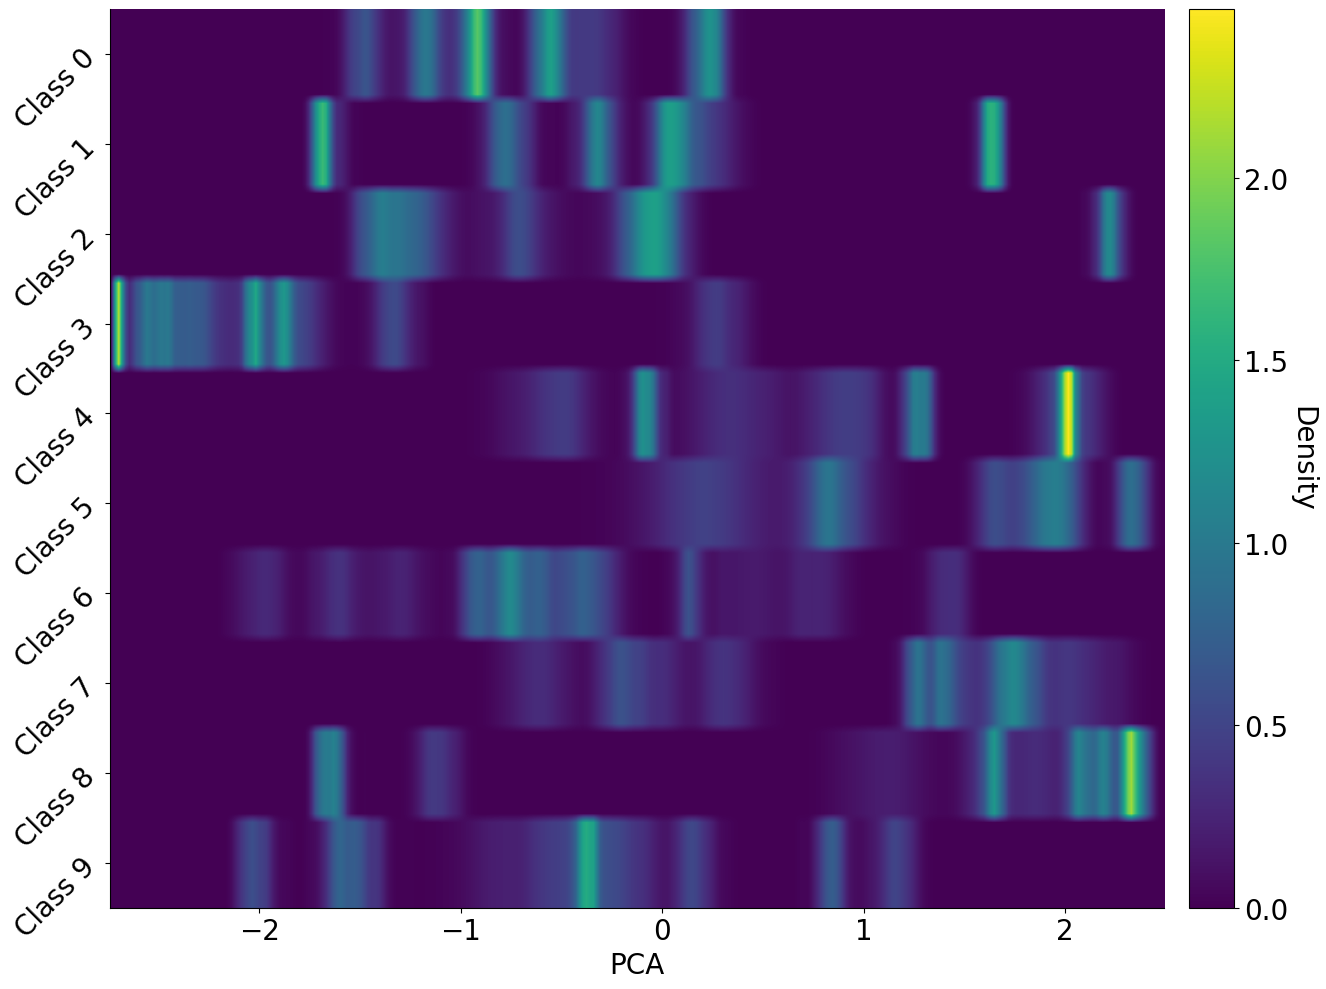

In [262]:
# ============================================================================
# 2D Heatmap Visualization: GMM distributions grouped by labels
# Clean view showing density variation across PCA Component 1
# ============================================================================

def visualize_gmm_1d_pca_heatmap(gmm_samples, cfg, labels=None, num_inputs=50, 
                                  palette='nature', use_delta=True,
                                  show_xlabel=True, show_ylabel=True, show_title=True,
                                  ticklabelsize_x=9, ticklabelsize_y=9,
                                  title_fontsize=14, label_fontsize=12,
                                  figsize=(12, 8), cmap='viridis',
                                  add_class_separators=True, separator_linewidth=1.5,
                                  normalize_class_width=True, rows_per_class=10,
                                  label_rotation=45,
                                  num_bins=200, save_path='gmm_heatmap_2d.png'):
    """
    Visualize GMM distributions as a 2D heatmap with inputs grouped by labels.
    
    Y-axis: Input index (grouped by class labels)
    X-axis: PCA Component 1
    Color intensity: Probability density
    
    Args:
        gmm_samples: Dictionary containing GMM samples with keys 'eps' and 'delta'
        cfg: Configuration dictionary
        labels: Labels for each input sample, shape (B,)
        num_inputs: Number of input samples to visualize
        palette: Color palette for class separator labels ('nature', 'science', 'cell', 'pnas')
        use_delta: If True, use 'delta' key from gmm_samples, otherwise use 'eps' (default: True)
        show_xlabel: Whether to show x-axis label (default: True)
        show_ylabel: Whether to show y-axis label (default: True)
        show_title: Whether to show plot title (default: True)
        ticklabelsize_x: Font size for x-axis tick labels (default: 9)
        ticklabelsize_y: Font size for y-axis tick labels (default: 9)
        title_fontsize: Font size for title (default: 14)
        label_fontsize: Font size for axis labels (default: 12)
        figsize: Figure size (width, height) (default: (12, 8))
        cmap: Colormap for density visualization (default: 'viridis')
               Options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 
                        'Blues', 'Greys', 'YlOrRd', 'RdPu'
        add_class_separators: Whether to add lines separating different classes (default: True)
        separator_linewidth: Width of class separator lines (default: 1.5)
        normalize_class_width: If True, all classes have equal band width (default: True)
        rows_per_class: Number of rows per class when normalize_class_width=True (default: 10)
        label_rotation: Rotation angle for class labels in degrees (default: 45)
        num_bins: Number of bins for PCA component axis (default: 200)
        save_path: Path to save the figure (default: 'gmm_heatmap_2d.png')
    
    Returns:
        fig, ax: Matplotlib figure and axes objects
        density_matrix: The computed density matrix
    """
    
    # Select which samples to use based on use_delta flag
    if use_delta:
        samples_tensor = gmm_samples['delta']
        if samples_tensor.dim() > 3:
            num_samples, B = samples_tensor.shape[0], samples_tensor.shape[1]
            samples_tensor = samples_tensor.reshape(num_samples, B, -1)
        latent_dim = samples_tensor.shape[2]
    else:
        samples_tensor = gmm_samples['eps']
        latent_dim = cfg['latent_dim']

    # Fit PCA on all samples
    all_samples = samples_tensor.reshape(-1, latent_dim).cpu().numpy()
    pca = PCA(n_components=1)
    pca.fit(all_samples)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")

    # Sort samples by label if labels provided
    if labels is not None:
        if hasattr(labels, 'cpu'):
            labels_np = labels.cpu().numpy()
        else:
            labels_np = np.array(labels)
        
        sorted_indices = np.argsort(labels_np[:num_inputs])
        labels_sorted = labels_np[sorted_indices]
        samples_sorted = samples_tensor[:, sorted_indices, :]
        
        print(f"Samples rearranged by label. Order: {labels_sorted}")
    else:
        sorted_indices = np.arange(num_inputs)
        labels_sorted = None
        samples_sorted = samples_tensor[:, :num_inputs, :]

    # Compute PCA projections for all inputs
    all_proj_1d = []
    for i in range(num_inputs):
        samples = samples_sorted[:, i, :].cpu().numpy()
        proj_1d = pca.transform(samples).flatten()
        all_proj_1d.append(proj_1d)

    # Get global range for PCA component
    global_min = min(proj.min() for proj in all_proj_1d)
    global_max = max(proj.max() for proj in all_proj_1d)
    
    # Create bins for PCA component
    pca_bins = np.linspace(global_min, global_max, num_bins)
    
    # Compute individual density matrix: (num_inputs, num_bins)
    individual_density_matrix = np.zeros((num_inputs, num_bins))
    
    for i in range(num_inputs):
        proj_1d = all_proj_1d[i]
        kde = gaussian_kde(proj_1d)
        individual_density_matrix[i, :] = kde(pca_bins)
    
    # Normalize class widths if requested
    if normalize_class_width and labels_sorted is not None:
        unique_labels = np.unique(labels_sorted)
        num_classes = len(unique_labels)
        
        print(f"Normalizing class widths: {num_classes} classes, {rows_per_class} rows each")
        
        # Create normalized density matrix
        density_matrix = np.zeros((num_classes * rows_per_class, num_bins))
        
        # Track class information
        class_info = []
        current_row = 0
        
        for class_idx, class_label in enumerate(unique_labels):
            # Get all samples belonging to this class
            class_mask = (labels_sorted == class_label)
            class_densities = individual_density_matrix[class_mask, :]
            
            num_samples_in_class = class_densities.shape[0]
            
            # Average density for this class
            avg_density = class_densities.mean(axis=0)
            
            # Replicate averaged density across rows_per_class rows
            for r in range(rows_per_class):
                density_matrix[current_row + r, :] = avg_density
            
            class_info.append({
                'label': class_label,
                'start_row': current_row,
                'end_row': current_row + rows_per_class - 1,
                'center_row': current_row + rows_per_class / 2 - 0.5,
                'num_samples': num_samples_in_class
            })
            
            current_row += rows_per_class
        
        total_rows = num_classes * rows_per_class
        print(f"Normalized density matrix shape: {density_matrix.shape}")
        
    else:
        # Use individual density matrix as-is
        density_matrix = individual_density_matrix
        total_rows = num_inputs
        class_info = None
        print(f"Density matrix shape: {density_matrix.shape}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    im = ax.imshow(density_matrix, aspect='auto', cmap=cmap, 
                   extent=[pca_bins[0], pca_bins[-1], total_rows-0.5, -0.5],
                   interpolation='bilinear', origin='upper')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Density', fontsize=label_fontsize, rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=ticklabelsize_y)
    
    # Add class separators and labels
    if add_class_separators:
        if normalize_class_width and class_info is not None:
            # Use class_info for normalized bands
            for i, info in enumerate(class_info):
                # Draw separator line (except before first class)
                if i > 0:
                    ax.axhline(y=info['start_row']-0.5, color='white', 
                              linewidth=separator_linewidth, linestyle='-', 
                              alpha=0.8, zorder=10)
            
            # Add class labels on the LEFT side (simple, no colors or sample counts)
            ax.set_yticks([info['center_row'] for info in class_info])
            ax.set_yticklabels([f'Class {int(info["label"])}' for info in class_info])
            ax.tick_params(axis='y', labelsize=ticklabelsize_y, rotation=label_rotation)
            
            # Set label properties (no colors, just plain black text)
            for i, info in enumerate(class_info):
                ax.get_yticklabels()[i].set_rotation(label_rotation)
                ax.get_yticklabels()[i].set_ha('right')  # Align to right for better appearance
                
        elif labels_sorted is not None:
            # Original behavior for non-normalized bands
            unique_labels = np.unique(labels_sorted)
            prev_label = labels_sorted[0]
            class_start = 0
            class_centers = []
            
            for i in range(1, len(labels_sorted)):
                if labels_sorted[i] != prev_label:
                    ax.axhline(y=i-0.5, color='white', linewidth=separator_linewidth, 
                              linestyle='-', alpha=0.8, zorder=10)
                    
                    class_center = (class_start + i - 1) / 2
                    class_centers.append((class_center, prev_label))
                    
                    class_start = i
                    prev_label = labels_sorted[i]
            
            # Add last class
            class_center = (class_start + len(labels_sorted) - 1) / 2
            class_centers.append((class_center, prev_label))
            
            # Add class labels on the LEFT side (simple, no colors)
            ax.set_yticks([center for center, _ in class_centers])
            ax.set_yticklabels([f'Class {int(label)}' for _, label in class_centers])
            ax.tick_params(axis='y', labelsize=ticklabelsize_y)
            
            # Set label properties (no colors, just plain black text)
            for i, (_, label) in enumerate(class_centers):
                ax.get_yticklabels()[i].set_rotation(label_rotation)
                ax.get_yticklabels()[i].set_ha('right')
    
    # Set labels
    if show_xlabel:
        ax.set_xlabel('PCA', fontsize=label_fontsize)
    if show_ylabel:
        ylabel_text = '' if normalize_class_width else 'Input Index'
        ax.set_ylabel(ylabel_text, fontsize=label_fontsize)
    
    if show_title:
        mode_str = cfg.get('cond_mode', 'unknown')
        normalized_str = ' (Normalized Width)' if normalize_class_width else ''
        # ax.set_title(f'GMM Density Heatmap (Grouped by Label){normalized_str}\nConditioning: {mode_str}', 
                    # fontsize=title_fontsize, pad=15)
    
    # Set tick parameters
    ax.tick_params(axis='x', labelsize=ticklabelsize_x)
    
    # Style the plot - clean borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()
    
    return fig, ax, density_matrix


# Example usage: 2D heatmap visualization with normalized class widths
print("\n" + "="*60)
print("Creating 2D heatmap visualization with normalized class widths...")
print("="*60)

fig, ax, density_matrix = visualize_gmm_1d_pca_heatmap(
    gmm_samples, 
    cfg, 
    labels=labels_for_plot, 
    num_inputs=100,
    palette='nature',
    use_delta=True,
    show_xlabel=True,
    show_ylabel=True,
    show_title=True,
    ticklabelsize_x=20,
    ticklabelsize_y=20,
    title_fontsize=20,
    label_fontsize=20,
    figsize=(14, 10),
    cmap='viridis',  # Try: 'plasma', 'inferno', 'magma', 'Blues', 'YlOrRd'
    add_class_separators=True,
    separator_linewidth=0.0,
    normalize_class_width=True,  # Normalize band widths
    rows_per_class=10,           # Rows per class
    label_rotation=45,           # Rotate labels to save space
    num_bins=300,
    # save_path='gmm_heatmap_2d_normalized.png'
)

# Alternative: Without normalized widths (original behavior)
# fig, ax, density_matrix = visualize_gmm_1d_pca_heatmap(
#     gmm_samples, cfg, labels=labels_for_plot, num_inputs=50,
#     use_delta=True, cmap='plasma', palette='science',
#     normalize_class_width=False,  # Keep original band widths
#     label_rotation=30,  # Less rotation for shorter labels
#     show_title=False, figsize=(12, 8)
# )

## t-SNE Visualization for Label-Conditional GMM
Visualize GMM samples conditioned only on y (labels) using t-SNE

Generating 500 samples for each of 10 classes...
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 0: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 1: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 2: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 3: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 4: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 5: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 6: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 7: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 8: generated 500 samples
  Delta shape: torch.Size([500, 1, 3, 32, 32])
  Class 9: generated 500 samples

Total samples: 5000, Latent dim: 3072

Applying t-SNE (perplexity=30, lr=200)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 sample

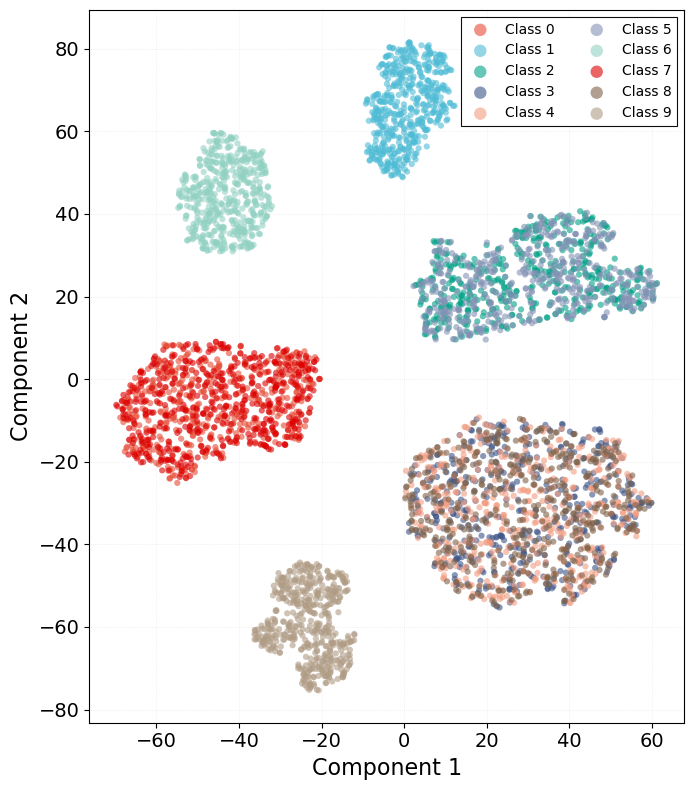


Visualization complete using nature palette!


In [25]:
# ============================================================================
# t-SNE Visualization: GMM samples conditioned on labels (y)
# ============================================================================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def plot_tsne_gmm_samples(
    gmm,
    cfg,
    test_dataset,
    device,
    out_shape,
    num_classes=10,
    samples_per_class=500,
    tsne_perplexity=30,
    tsne_learning_rate=200,
    palette='nature',
    show_title=True,
    show_xlabel=True,
    show_ylabel=True,
    ticklabelsize_x=9,
    ticklabelsize_y=9,
    legend_fontsize=9,
    figsize=(10, 8),
    save_path=None
):
    """
    Generate and visualize t-SNE embedding of GMM samples conditioned on labels.
    
    Parameters
    ----------
    gmm : GMM4PR
        Trained GMM model
    cfg : dict
        Configuration dictionary containing GMM settings
    test_dataset : Dataset
        Test dataset to use for generating samples
    device : str
        Device to use ('cuda' or 'cpu')
    out_shape : tuple
        Output shape for samples (C, H, W)
    num_classes : int
        Number of classes (default: 10 for CIFAR-10)
    samples_per_class : int
        Number of samples to generate per class (default: 500)
    tsne_perplexity : int
        t-SNE perplexity parameter (default: 30)
    tsne_learning_rate : int
        t-SNE learning rate (default: 200)
    palette : str
        Color palette ('nature' or 'science', default: 'nature')
    show_title : bool
        Whether to show the plot title (default: True)
    show_xlabel : bool
        Whether to show x-axis label (default: True)
    show_ylabel : bool
        Whether to show y-axis label (default: True)
    ticklabelsize_x : int
        Font size for x-axis tick labels (default: 9)
    ticklabelsize_y : int
        Font size for y-axis tick labels (default: 9)
    legend_fontsize : int
        Font size for legend text (default: 9)
    figsize : tuple
        Figure size (width, height) (default: (10, 8))
    save_path : str or None
        Path to save the figure. If None, saves to 'gmm_tsne_label_conditional.png'
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    ax : matplotlib.axes.Axes
        The axes object
    samples_tsne : numpy.ndarray
        t-SNE embedded samples
    all_labels : numpy.ndarray
        Labels for all samples
    """
    
    # Check if GMM is conditioned on y
    if cfg.get('cond_mode') not in ['y', 'xy']:
        print(f"Warning: Current GMM is conditioned on '{cfg.get('cond_mode')}', not 'y' or 'xy'.")
        print("This visualization is designed for label-conditional GMMs.")
    
    # Generate samples for each class
    all_samples = []
    all_labels = []
    
    print(f"Generating {samples_per_class} samples for each of {num_classes} classes...")
    
    for class_id in range(num_classes):
        # Create label tensor for this class
        y_class = torch.tensor([class_id], device=device)
        
        # Generate samples conditioned on this class label
        if cfg.get('cond_mode') == 'y':
            gmm_class_samples = gmm.sample(y=y_class, num_samples=samples_per_class, out_shape=out_shape)
        elif cfg.get('cond_mode') == 'xy':
            # For xy mode, we need a dummy x input - use a random sample from this class
            # Get a sample image from this class
            class_indices = [i for i, (_, label, _) in enumerate(test_dataset) if label == class_id]
            if class_indices:
                x_sample, _, _ = test_dataset[class_indices[0]]
                x_sample = x_sample.unsqueeze(0).to(device)
                gmm_class_samples = gmm.sample(x=x_sample, y=y_class, num_samples=samples_per_class)
            else:
                continue
        else:
            # For unconditional or x-only, just sample normally
            gmm_class_samples = gmm.sample(num_samples=samples_per_class)
        
        # Extract delta samples and reshape to 2D
        # delta shape: [num_samples, 1, latent_dim] -> [num_samples, latent_dim]
        delta_tensor = gmm_class_samples['delta']
        print(f"  Delta shape: {delta_tensor.shape}")
        # Flatten to 2D: [num_samples, -1]
        samples_class = delta_tensor.reshape(delta_tensor.shape[0], -1).cpu().numpy()
        
        all_samples.append(samples_class)
        all_labels.extend([class_id] * len(samples_class))
        
        print(f"  Class {class_id}: generated {len(samples_class)} samples")
    
    # Concatenate all samples
    all_samples = np.vstack(all_samples)  # Shape: [num_classes * samples_per_class, latent_dim]
    all_labels = np.array(all_labels)
    
    print(f"\nTotal samples: {all_samples.shape[0]}, Latent dim: {all_samples.shape[1]}")
    
    # Apply t-SNE
    print(f"\nApplying t-SNE (perplexity={tsne_perplexity}, lr={tsne_learning_rate})...")
    tsne = TSNE(
        n_components=2,
        perplexity=tsne_perplexity,
        learning_rate=tsne_learning_rate,
        max_iter=1000,
        random_state=42,
        verbose=1
    )
    
    samples_tsne = tsne.fit_transform(all_samples)
    
    print(f"t-SNE completed. Embedding shape: {samples_tsne.shape}")
    
    # Define color palettes
    palettes = {
        'nature': [
            '#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F',
            '#8491B4', '#91D1C2', '#DC0000', '#7E6148', '#B09C85',
        ],
        'science': [
            '#3B4992', '#EE0000', '#008B45', '#631879', '#008280',
            '#BB0021', '#5F559B', '#A20056', '#808180', '#1B1919',
        ],
    }
    
    # Select palette
    palette_colors = palettes.get(palette, palettes['nature'])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    for class_id in range(num_classes):
        mask = all_labels == class_id
        color = palette_colors[class_id % len(palette_colors)]
        
        ax.scatter(
            samples_tsne[mask, 0],
            samples_tsne[mask, 1],
            c=[color],
            label=f'Class {class_id}',
            alpha=0.6,
            s=20,
            edgecolors='none'
        )
    
    # Set labels conditionally
    if show_xlabel:
        ax.set_xlabel('Component 1', fontsize=16)
    if show_ylabel:
        ax.set_ylabel('Component 2', fontsize=16)

    # Set title conditionally
    if show_title:
        ax.set_title(f't-SNE Visualization of GMM Samples (Conditioned on Labels)\nMode: {cfg.get("cond_mode")}', 
                     fontsize=14, pad=20)
    
    # Set tick label sizes
    ax.tick_params(axis='x', labelsize=ticklabelsize_x)
    ax.tick_params(axis='y', labelsize=ticklabelsize_y)
    
    # Add legend with larger square markers for better readability
    legend = ax.legend(loc='best', fontsize=legend_fontsize, framealpha=0.95, 
                      frameon=True, fancybox=False, ncol=2,
                      markerscale=3.0)  # Make markers 3x larger
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(0.8)
    
    # Update legend marker style to squares
    for handle in legend.legend_handles:
        handle.set_sizes([80])  # Larger square size
    
    # Clean up axes
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    # Save figure
    if save_path is None:
        save_path = 'gmm_tsne_label_conditional.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved: {save_path}")
    
    plt.show()
    
    print(f"\nVisualization complete using {palette} palette!")
    
    return fig, ax, samples_tsne, all_labels


# Example usage with default settings
# fig, ax, samples_tsne, labels = plot_tsne_gmm_samples(
#     gmm=gmm,
#     cfg=cfg,
#     test_dataset=test_dataset,
#     device=DEVICE,
#     out_shape=out_shape,
#     num_classes=10,
#     samples_per_class=500,
#     palette='nature'
# )

# Example: Hide title and axis labels with custom tick and legend sizes
fig, ax, samples_tsne, labels = plot_tsne_gmm_samples(
    gmm=gmm,
    cfg=cfg,
    test_dataset=test_dataset,
    device=DEVICE,
    out_shape=out_shape,
    show_title=False,
    show_xlabel=True,
    show_ylabel=True,
    ticklabelsize_x=14,
    ticklabelsize_y=14,
    legend_fontsize=10
)